# Use [markdown](https://www.markdownguide.org/basic-syntax/) to label each (sub)question neatly.

This notebook serves as your report. All your answers should be presented within it. 

You can submit multiple notebooks (e.g. 1 notebook per part / question).

Before submission, remember to tidy up the notebook and retain only relevant parts.

In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [2]:
import graphviz
import pydot_ng as pydot
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup

In [3]:
pydot.find_graphviz()

{'dot': 'C:\\Program Files\\Graphviz\\bin\\dot.exe',
 'twopi': 'C:\\Program Files\\Graphviz\\bin\\twopi.exe',
 'neato': 'C:\\Program Files\\Graphviz\\bin\\neato.exe',
 'circo': 'C:\\Program Files\\Graphviz\\bin\\circo.exe',
 'fdp': 'C:\\Program Files\\Graphviz\\bin\\fdp.exe',
 'sfdp': 'C:\\Program Files\\Graphviz\\bin\\sfdp.exe'}

In [4]:
import pandas as pd
global df
df = pd.read_csv('hdb_price_prediction.csv')
df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133407,6,2022,877 YISHUN STREET 81,Khatib,0.475885,12.738721,0.016807,0.000968,"EXECUTIVE, Maisonette",64.583333,145.0,07 TO 09,810000.0
133408,1,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",65.000000,164.0,04 TO 06,785000.0
133409,2,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.916667,171.0,04 TO 06,842000.0
133410,2,2022,632 YISHUN STREET 61,Khatib,0.700595,13.222912,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.750000,164.0,10 TO 12,845000.0


In [5]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [6]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))


In [7]:


def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133412 entries, 0 to 133411
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   month                   133412 non-null  int64  
 1   year                    133412 non-null  int64  
 2   full_address            133412 non-null  object 
 3   nearest_stn             133412 non-null  object 
 4   dist_to_nearest_stn     133412 non-null  float64
 5   dist_to_dhoby           133412 non-null  float64
 6   degree_centrality       133412 non-null  float64
 7   eigenvector_centrality  133412 non-null  float64
 8   flat_model_type         133412 non-null  object 
 9   remaining_lease_years   133412 non-null  float64
 10  floor_area_sqm          133412 non-null  float64
 11  storey_range            133412 non-null  object 
 12  resale_price            133412 non-null  float64
dtypes: float64(7), int64(2), object(4)
memory usage: 13.2+ MB


In [9]:
# Split data

train_dataframe = df[df['year']<= 2020] 
test_dataframe =  df[df['year']>2020]

In [10]:
train_dataframe.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [11]:
test_dataframe.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
87370,1,2021,170 ANG MO KIO AVENUE 4,Yio Chu Kang,1.276775,8.339960,0.016807,0.002459,"2 ROOM, Improved",64.083333,45.0,07 TO 09,225000.0
87371,1,2021,170 ANG MO KIO AVENUE 4,Yio Chu Kang,1.276775,8.339960,0.016807,0.002459,"2 ROOM, Improved",64.083333,45.0,01 TO 03,211000.0
87372,1,2021,216 ANG MO KIO AVENUE 1,Ang Mo Kio,0.994153,7.427003,0.016807,0.006243,"3 ROOM, New Generation",54.333333,73.0,04 TO 06,275888.0
87373,1,2021,223 ANG MO KIO AVENUE 1,Ang Mo Kio,1.349574,7.444314,0.016807,0.006243,"3 ROOM, New Generation",56.083333,67.0,07 TO 09,316800.0
87374,1,2021,223 ANG MO KIO AVENUE 1,Ang Mo Kio,1.349574,7.444314,0.016807,0.006243,"3 ROOM, New Generation",56.000000,67.0,10 TO 12,305000.0


In [12]:
global train_dataframe
global test_dataframe

category_not_used = ["full_address", "nearest_stn"]
train_dataframe = train_dataframe.drop(category_not_used, axis = 1)
test_dataframe = test_dataframe.drop(category_not_used, axis = 1)

train_ds = dataframe_to_dataset(train_dataframe)
test_ds = dataframe_to_dataset(test_dataframe)

train_ds = train_ds.batch(128)
test_ds = test_ds.batch(128)

Question 1a) Reason for the way of splitting

In [13]:
global month, storey_range, flat_model_type, floor_area_sqm, remaining_lease_years, degree_centrality, eigenvector_centrality, dist_to_nearest_stn, dist_to_dhoby
global month_encoded, storey_range_encoded, flat_model_type_encoded, floor_area_sqm_encoded, remaining_lease_year_encoded, degree_centrality_encoded, eigenvector_centrality_encoded, dist_to_nearest_stn_encoded, dist_to_dhoby_encoded

In [14]:
#Categorical feature encoded as integer
month = keras.Input(shape=(1,), name="month", dtype="int64")

# Categorical feature encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

# Numerical features
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
#resale_price = keras.Input(shape=(1,), name="resale_price")

all_inputs = [month,flat_model_type,storey_range,dist_to_nearest_stn,
            dist_to_dhoby,degree_centrality,eigenvector_centrality,remaining_lease_years,floor_area_sqm]


#Integer categorical features
month_encoded = encode_categorical_feature(month, "month",train_ds, False)

#String categorical features
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type",train_ds, True)
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range",train_ds, True)

#Numerical features
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
remaining_lease_year_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm,"floor_area_sqm", train_ds)

all_features = layers.Concatenate()(
                [
                    month_encoded,
                    storey_range_encoded,
                    flat_model_type_encoded,
                    floor_area_sqm_encoded,
                    remaining_lease_year_encoded,
                    degree_centrality_encoded,
                    eigenvector_centrality_encoded,
                    dist_to_nearest_stn_encoded,
                    dist_to_dhoby_encoded
                ]
)
output = layers.Dense(1, activation="linear")(all_features)
adam_model = keras.Model(all_inputs, output)
adam_model.compile(optimizer="adam", loss= root_mean_squared_error,metrics=[r2])


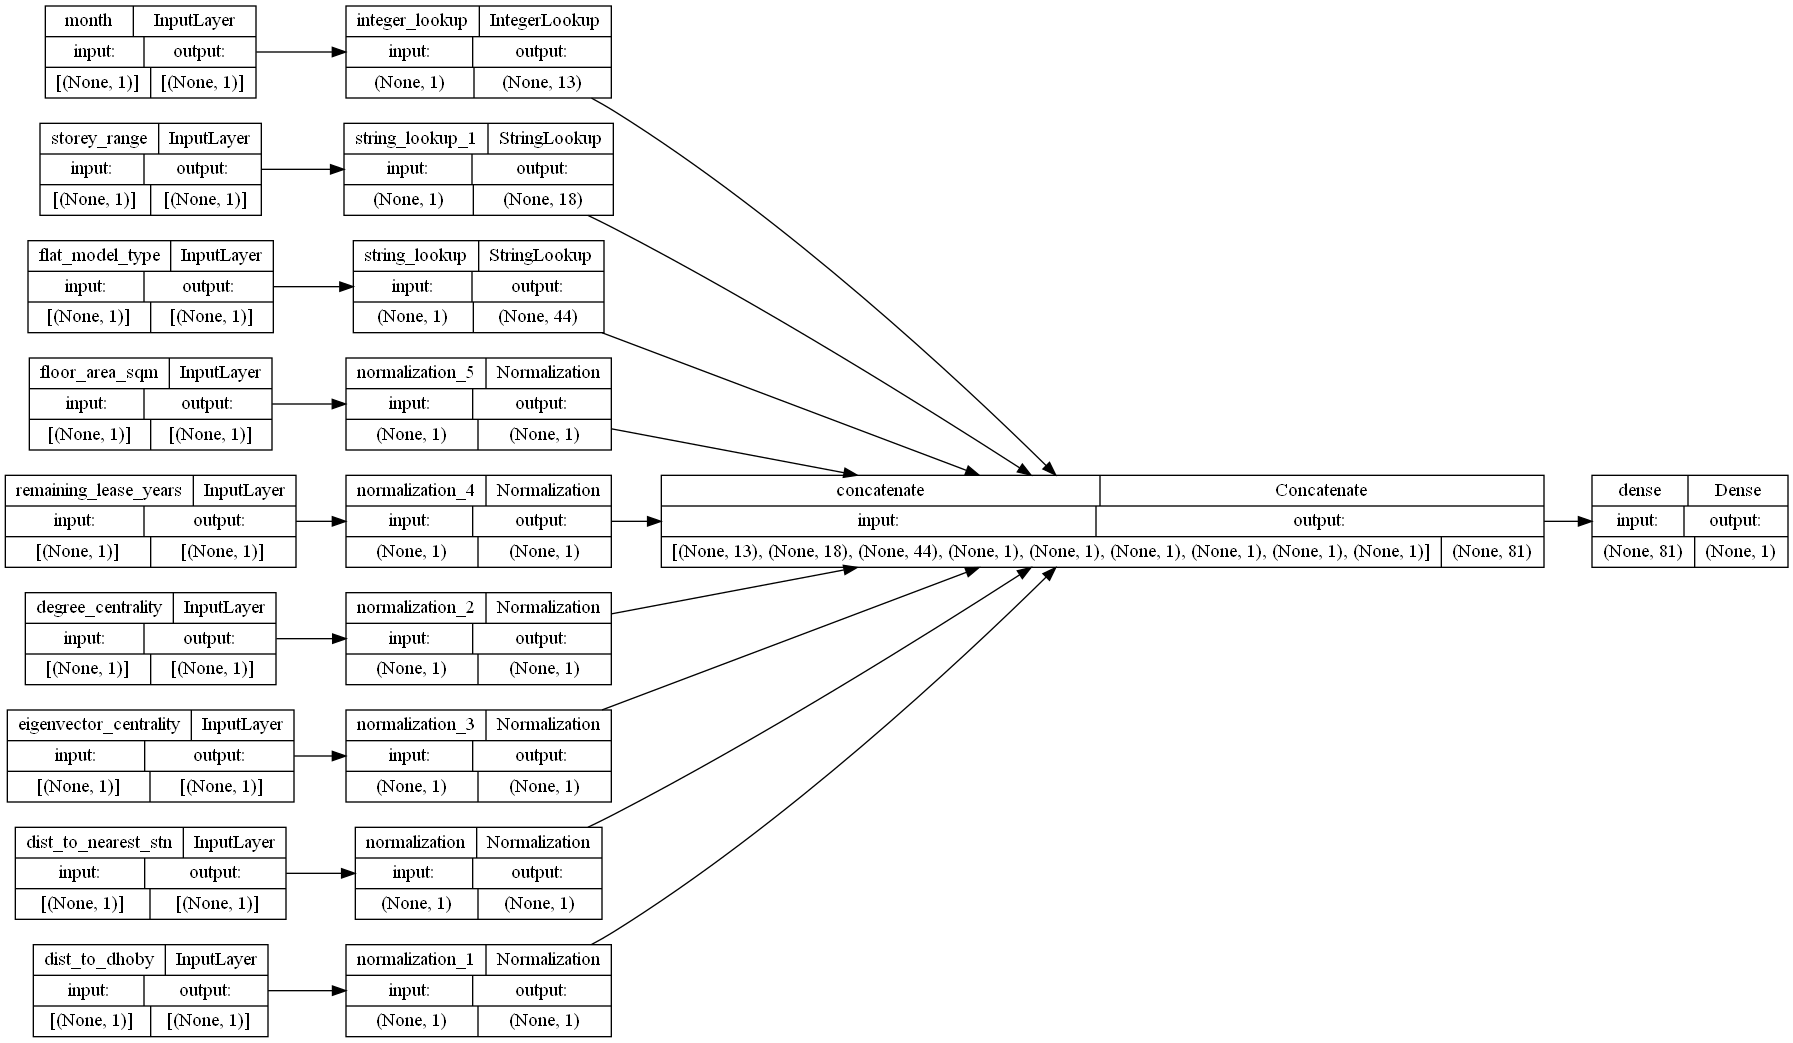

In [15]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(adam_model, show_shapes=True, rankdir="LR")

Q1C) Training adam model and SGD model 

In [16]:
history = {}
no_epochs = 50
batch_size = 256
history["adam_model"] = adam_model.fit(train_ds, epochs=no_epochs,batch_size=batch_size, validation_data=test_ds, verbose=2)

Epoch 1/50


c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py:566: UserWarning: Input dict contained keys ['year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


683/683 - 6s - loss: 468350.2500 - r2: -8.4602e+00 - val_loss: 548812.9375 - val_r2: -1.0228e+01 - 6s/epoch - 9ms/step
Epoch 2/50
683/683 - 4s - loss: 468338.7188 - r2: -8.4693e+00 - val_loss: 548812.6875 - val_r2: -1.0223e+01 - 4s/epoch - 6ms/step
Epoch 3/50
683/683 - 4s - loss: 468334.2500 - r2: -8.4812e+00 - val_loss: 548835.3750 - val_r2: -1.0241e+01 - 4s/epoch - 6ms/step
Epoch 4/50
683/683 - 4s - loss: 468336.9375 - r2: -8.4737e+00 - val_loss: 548809.9375 - val_r2: -1.0229e+01 - 4s/epoch - 6ms/step
Epoch 5/50
683/683 - 4s - loss: 468345.9688 - r2: -8.4645e+00 - val_loss: 548803.7500 - val_r2: -1.0264e+01 - 4s/epoch - 6ms/step
Epoch 6/50
683/683 - 4s - loss: 468320.5312 - r2: -8.4660e+00 - val_loss: 548809.3125 - val_r2: -1.0254e+01 - 4s/epoch - 6ms/step
Epoch 7/50
683/683 - 4s - loss: 468320.8438 - r2: -8.4574e+00 - val_loss: 548845.7500 - val_r2: -1.0219e+01 - 4s/epoch - 6ms/step
Epoch 8/50
683/683 - 4s - loss: 468332.3750 - r2: -8.4621e+00 - val_loss: 548807.4375 - val_r2: -1.02

In [17]:
custom_optimizer=tf.keras.optimizers.SGD(learning_rate=0.01)
sgd_model = keras.Model(all_inputs, output)
sgd_model.compile(optimizer=custom_optimizer, loss=root_mean_squared_error, metrics=r2)
history["sgd_model"] = sgd_model.fit(train_ds, epochs=no_epochs,batch_size=batch_size, validation_data=test_ds, verbose=2)

Epoch 1/50
683/683 - 5s - loss: 468196.4688 - r2: -8.4726e+00 - val_loss: 548677.5625 - val_r2: -1.0241e+01 - 5s/epoch - 7ms/step
Epoch 2/50
683/683 - 4s - loss: 468177.9062 - r2: -8.4799e+00 - val_loss: 548660.5625 - val_r2: -1.0233e+01 - 4s/epoch - 6ms/step
Epoch 3/50
683/683 - 4s - loss: 468182.5000 - r2: -8.4602e+00 - val_loss: 548693.3125 - val_r2: -1.0184e+01 - 4s/epoch - 6ms/step
Epoch 4/50
683/683 - 4s - loss: 468173.3125 - r2: -8.4637e+00 - val_loss: 548659.8125 - val_r2: -1.0191e+01 - 4s/epoch - 6ms/step
Epoch 5/50
683/683 - 4s - loss: 468159.8125 - r2: -8.4573e+00 - val_loss: 548621.8125 - val_r2: -1.0226e+01 - 4s/epoch - 6ms/step
Epoch 6/50
683/683 - 4s - loss: 468169.0000 - r2: -8.4534e+00 - val_loss: 548627.3750 - val_r2: -1.0226e+01 - 4s/epoch - 6ms/step
Epoch 7/50
683/683 - 4s - loss: 468133.4062 - r2: -8.4742e+00 - val_loss: 548645.5000 - val_r2: -1.0213e+01 - 4s/epoch - 6ms/step
Epoch 8/50
683/683 - 4s - loss: 468119.6875 - r2: -8.4727e+00 - val_loss: 548637.4375 - va

In [18]:
print("R^2 value for Adam: {}".format(history["adam_model"].history["val_r2"][-1]))
print("R^2 value for SGD: {}".format(history["sgd_model"].history["val_r2"][-1]))

R^2 value for Adam: -10.19415283203125
R^2 value for SGD: -10.195039749145508


In [19]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.08)
hidden_layer = layers.Dense(10, activation ="linear")(all_features)
Q1D_output = layers.Dense(1, activation="linear")(hidden_layer)
Q1D_adam_model = keras.Model(all_inputs, Q1D_output)
Q1D_adam_model.compile(optimizer=adam_optimizer, loss= root_mean_squared_error,metrics=[r2])

In [20]:
history["Q1D_adam_model"] = Q1D_adam_model.fit(train_ds, epochs=no_epochs,batch_size=batch_size, validation_data=test_ds, verbose=2)

Epoch 1/50
683/683 - 5s - loss: 370137.5312 - r2: -5.2333e+00 - val_loss: 254044.3438 - val_r2: -1.4021e+00 - 5s/epoch - 7ms/step
Epoch 2/50
683/683 - 4s - loss: 85257.0859 - r2: 0.6580 - val_loss: 110531.2578 - val_r2: 0.5476 - 4s/epoch - 6ms/step
Epoch 3/50
683/683 - 4s - loss: 66820.1250 - r2: 0.8073 - val_loss: 106626.9297 - val_r2: 0.5791 - 4s/epoch - 6ms/step
Epoch 4/50
683/683 - 4s - loss: 64005.5078 - r2: 0.8232 - val_loss: 106407.9062 - val_r2: 0.5798 - 4s/epoch - 6ms/step
Epoch 5/50
683/683 - 4s - loss: 62661.9609 - r2: 0.8306 - val_loss: 103603.9062 - val_r2: 0.6017 - 4s/epoch - 6ms/step
Epoch 6/50
683/683 - 4s - loss: 61877.8633 - r2: 0.8346 - val_loss: 103798.8281 - val_r2: 0.6004 - 4s/epoch - 6ms/step
Epoch 7/50
683/683 - 4s - loss: 61422.8984 - r2: 0.8368 - val_loss: 104885.0156 - val_r2: 0.5926 - 4s/epoch - 6ms/step
Epoch 8/50
683/683 - 4s - loss: 61139.0547 - r2: 0.8379 - val_loss: 103767.1484 - val_r2: 0.5988 - 4s/epoch - 6ms/step
Epoch 9/50
683/683 - 4s - loss: 60903

Q1E Compare the performance of 1C and 1D and suggest reasons for the observations

Q2

In [21]:
Q2_validation_dataframe = train_dataframe[train_dataframe["year"]==2020]
Q2_train_dataframe = train_dataframe[train_dataframe["year"]<2020]


In [22]:
global Q2_train_ds
global Q2_val_ds

Q2_train_ds = dataframe_to_dataset(Q2_train_dataframe)
Q2_val_ds = dataframe_to_dataset(Q2_validation_dataframe)

Q2_train_ds = Q2_train_ds.batch(128)
Q2_val_ds = Q2_val_ds.batch(128)

In [23]:
from math import floor


In [24]:
def Q2_encode_categorical_feature(feature, name, dataset, is_string, num_categories, divisor):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="int")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x,-1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)

    emb = layers.Embedding(input_dim=num_categories+1, output_dim=floor(num_categories//divisor))
    embedded = emb(encoded_feature)

    return layers.Flatten()(embedded)


In [25]:
global callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


In [26]:
#Numerical features
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", Q2_train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", Q2_train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", Q2_train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", Q2_train_ds)
remaining_lease_year_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", Q2_train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm,"floor_area_sqm", Q2_train_ds)

In [27]:
import keras_tuner

def build_model(hp):
    global Q2_output
    global Q2_optimizer
    
    Q2_optimizer = tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 2e-1, sampling='log'))
    divisor = hp.Int("divisor", min_value=1, max_value=2, step=1)

    hidden_units = hp.Int("hidden_units", min_value=4, max_value=32, step=4)
    

    month_num_categories = df["month"].nunique()
    flat_model_type_num_categories = df["flat_model_type"].nunique()
    storey_range_num_categories = df["storey_range"].nunique()


    #Integer categorical features
    month_embedded = Q2_encode_categorical_feature(month, "month",Q2_train_ds, False, month_num_categories, divisor)
    #String categorical features
    flat_model_type_embedded = Q2_encode_categorical_feature(flat_model_type, "flat_model_type",Q2_train_ds, True, flat_model_type_num_categories, divisor)
    storey_range_embedded = Q2_encode_categorical_feature(storey_range, "storey_range",Q2_train_ds, True, storey_range_num_categories, divisor)
    
    Q2_all_features = layers.Concatenate()(
                    [
                        month_embedded,
                        storey_range_embedded,
                        flat_model_type_embedded,
                        floor_area_sqm_encoded,
                        remaining_lease_year_encoded,
                        degree_centrality_encoded,
                        eigenvector_centrality_encoded,
                        dist_to_nearest_stn_encoded,
                        dist_to_dhoby_encoded
                    ]
        )
    hidden_layer = layers.Dense(units=hidden_units, activation ="linear")(Q2_all_features)
    Q2_output = layers.Dense(1, activation="linear")(hidden_layer)
    Q2_model = keras.Model(all_inputs, Q2_output)
    Q2_model.compile(optimizer=Q2_optimizer, loss= root_mean_squared_error,metrics=[r2])

    return Q2_model
    


In [28]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10)

# Use Q2_train_ds or train_ds? Assume use Q2_train_ds first
tuner.search(Q2_train_ds, epochs=50, validation_data=Q2_val_ds, callbacks=[callback])
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

Trial 10 Complete [00h 03m 47s]
val_loss: 347471.65625

Best val_loss So Far: 60780.84375
Total elapsed time: 00h 30m 15s
INFO:tensorflow:Oracle triggered exit


Q2D

In [30]:
Q2_best_model_history = {}
Q2_best_model = build_model(best_hyperparameters)

# Train on the non-test split ( 2020 and before hence using train_ds instead of Q2_train_ds)
Q2_best_model_history["best_model"] = Q2_best_model.fit(train_ds, epochs=50, validation_data = Q2_val_ds, verbose=2, batch_size=batch_size)

Epoch 1/50
683/683 - 5s - loss: 140926.9531 - r2: -3.9561e-01 - val_loss: 83663.3828 - val_r2: 0.6988 - 5s/epoch - 8ms/step
Epoch 2/50
683/683 - 5s - loss: 80310.6875 - r2: 0.7216 - val_loss: 74778.2266 - val_r2: 0.7599 - 5s/epoch - 7ms/step
Epoch 3/50
683/683 - 5s - loss: 71889.7891 - r2: 0.7762 - val_loss: 67897.2188 - val_r2: 0.8017 - 5s/epoch - 7ms/step
Epoch 4/50
683/683 - 5s - loss: 67118.3125 - r2: 0.8050 - val_loss: 64477.0078 - val_r2: 0.8204 - 5s/epoch - 7ms/step
Epoch 5/50
683/683 - 5s - loss: 64301.7227 - r2: 0.8210 - val_loss: 63851.1406 - val_r2: 0.8251 - 5s/epoch - 7ms/step
Epoch 6/50
683/683 - 5s - loss: 62617.0547 - r2: 0.8304 - val_loss: 61324.7266 - val_r2: 0.8379 - 5s/epoch - 7ms/step
Epoch 7/50
683/683 - 5s - loss: 61827.7070 - r2: 0.8344 - val_loss: 60847.6016 - val_r2: 0.8404 - 5s/epoch - 7ms/step
Epoch 8/50
683/683 - 5s - loss: 61373.9570 - r2: 0.8371 - val_loss: 62007.4414 - val_r2: 0.8351 - 5s/epoch - 7ms/step
Epoch 9/50
683/683 - 5s - loss: 61123.3281 - r2: 0

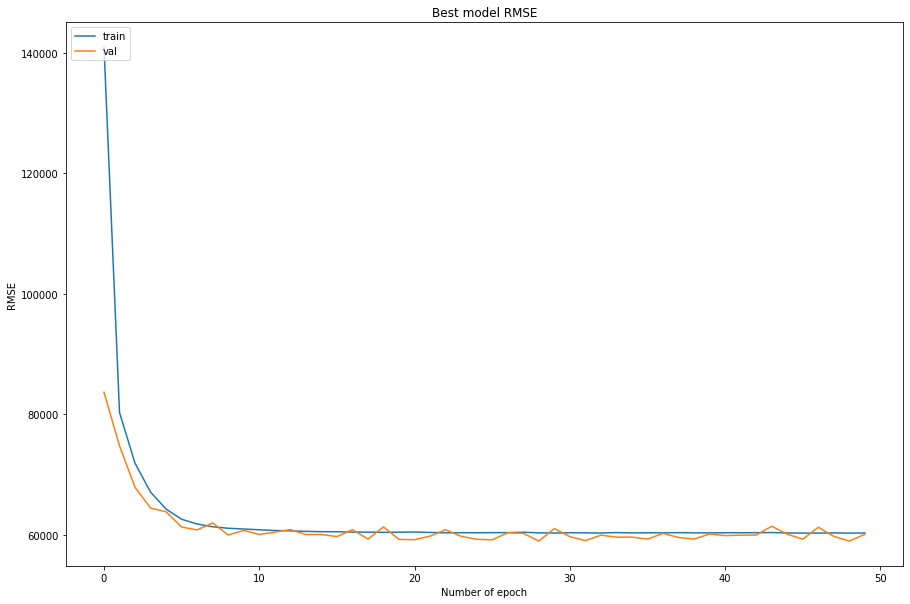

In [31]:
import matplotlib.pyplot as plt
plt_1 = plt.figure(figsize=(15, 10))
plt.plot(Q2_best_model_history['best_model'].history['loss'])
plt.plot(Q2_best_model_history['best_model'].history['val_loss'])
plt.title('Best model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Number of epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.savefig('figures/1a_accuracy.png')
plt.show()

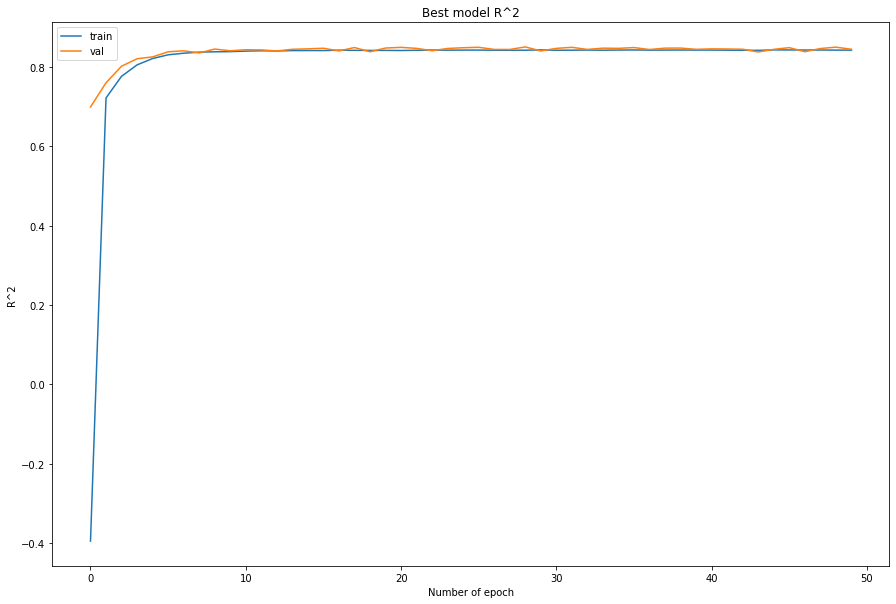

In [32]:
import matplotlib.pyplot as plt
plt_1 = plt.figure(figsize=(15, 10))
plt.plot(Q2_best_model_history['best_model'].history['r2'])
plt.plot(Q2_best_model_history['best_model'].history['val_r2'])
plt.title('Best model R^2')
plt.ylabel('R^2')
plt.xlabel('Number of epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.savefig('figures/1a_accuracy.png')
plt.show()

In [33]:
print("Train R^2 value: {}".format(Q2_best_model_history["best_model"].history["r2"][-1]))
print("Val R^2 value: {}".format(Q2_best_model_history["best_model"].history["val_r2"][-1]))

Train R^2 value: 0.842042088508606
Val R^2 value: 0.8443419933319092


In [34]:

best_model_df = pd.DataFrame(Q2_best_model_history['best_model'].history["val_loss"], columns=["val_rmse"])
best_model_df["val_R^2"] = Q2_best_model_history["best_model"].history["val_r2"]
best_model_df = best_model_df.sort_values(by='val_rmse', ascending=False)
best_model_df.head(30)

,val_rmse,val_R^2
0,83663.382812,0.698760
1,74778.226562,0.759874
2,67897.218750,0.801655
3,64477.007812,0.820431
4,63851.140625,0.825121
7,62007.441406,0.835081
43,61464.648438,0.837503
18,61347.468750,0.838050
5,61324.726562,0.837929
46,61294.574219,0.838186


List down the trends

In [35]:
# old test set
Q3_old_df = pd.read_csv('hdb_price_prediction_old.csv')

Q3_old_test_df = Q3_old_df[Q3_old_df["year"]>2020].copy()
Q3_old_test_df = Q3_old_test_df.drop(category_not_used, axis = 1)
Q3_old_test_ds = dataframe_to_dataset(Q3_old_test_df)
Q3_old_test_ds = Q3_old_test_ds.batch(128)

# new test set
Q3_new_test_2021_df = test_dataframe[test_dataframe["year"]==2021].copy()
Q3_new_test_2022_df = test_dataframe[test_dataframe["year"]==2022].copy()

Q3_new_test_2021_ds = dataframe_to_dataset(Q3_new_test_2021_df)
Q3_new_test_2022_ds = dataframe_to_dataset(Q3_new_test_2022_df)

Q3_new_test_2021_ds = Q3_new_test_2021_ds.batch(128)
Q3_new_test_2022_ds = Q3_new_test_2022_ds.batch(128)


In [36]:
Q3_new_test_2022_df

,month,year,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
116427,2,2022,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",56.333333,44.0,04 TO 06,235000.0
116428,1,2022,0.313515,7.603794,0.016807,0.006243,"2 ROOM, Improved",54.416667,44.0,07 TO 09,245000.0
116429,2,2022,0.423605,7.430263,0.016807,0.006243,"2 ROOM, Improved",55.000000,44.0,07 TO 09,238888.0
116430,5,2022,0.423605,7.430263,0.016807,0.006243,"2 ROOM, Improved",54.750000,44.0,04 TO 06,243000.0
116431,7,2022,0.423605,7.430263,0.016807,0.006243,"2 ROOM, Improved",54.583333,44.0,07 TO 09,243000.0
...,...,...,...,...,...,...,...,...,...,...,...
133407,6,2022,0.475885,12.738721,0.016807,0.000968,"EXECUTIVE, Maisonette",64.583333,145.0,07 TO 09,810000.0
133408,1,2022,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",65.000000,164.0,04 TO 06,785000.0
133409,2,2022,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.916667,171.0,04 TO 06,842000.0
133410,2,2022,0.700595,13.222912,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.750000,164.0,10 TO 12,845000.0


In [37]:
old_test_loss, old_test_R2 = Q2_best_model.evaluate(Q3_old_test_ds)
print('Old Test RMSE: %f' % old_test_loss)
print('Old Test R^2: %f' % old_test_R2)

new_test_2021_loss, new_test_2021_R2 = Q2_best_model.evaluate(Q3_new_test_2021_ds)
print('Test RMSE_2021: %f' % new_test_2021_loss)
print('Test R^2_2021: %f' % new_test_2021_R2)

new_test_2022_loss, new_test_2022_R2 = Q2_best_model.evaluate(Q3_new_test_2022_ds)
print('Test RMSE_2022: %f' % new_test_2022_loss)
print('Test R^2_2022: %f' % new_test_2022_R2)

131/131 [==============================] - 1s 4ms/step - loss: 79423.9375 - r2: 0.7520
Old Test RMSE: 79423.937500
Old Test R^2: 0.752010
228/228 [==============================] - 1s 4ms/step - loss: 87152.0000 - r2: -508910272249856.0000
Test RMSE_2021: 87152.000000
Test R^2_2021: -508910272249856.000000
133/133 [==============================] - 1s 4ms/step - loss: 126613.1406 - r2: 0.4267
Test RMSE_2022: 126613.140625
Test R^2_2022: 0.426736


Q3B Ans

Q3C

Identifying Covariate shift 

In [62]:
# As we used train_ds for best_model, we are going to use train_dataframe

train_df_shift = train_dataframe.copy()
old_test_df_shift = Q3_old_test_df.copy()
test_df_2021_shift = Q3_new_test_2021_df.copy()
test_df_2022_shift = Q3_new_test_2022_df.copy()

In [63]:
train_df_shift.head()

,month,year,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [64]:
from sklearn.model_selection import cross_val_score

In [85]:

def detect_covariate_shift(data_train, data_test, threshold=0.8):

    df_train = data_train.copy()
    df_test = data_test.copy()

    df_train['is_train'] = 1
    df_test['is_train'] = 0
    
    df_train = df_train.sample(7000, random_state=0)
    df_test = df_test.sample(7000, random_state=0)

    combined_set = df_train.append(df_test)
    y_label = combined_set[["is_train"]]

    combined_set.drop('is_train', axis=1, inplace=True)
   
    combined_set_ds = dataframe_to_dataset(combined_set)
    y_label_ds = tf.data.Dataset.from_tensor_slices((dict(y_label)))
    y_label_ds = y_label_ds.shuffle(buffer_size=len(y_label))

    combined_set_ds=combined_set_ds.batch(128)
    y_label_ds = y_label_ds.batch(128)

    print(y_label_ds)
    # Modelling
    model = keras.Model(all_inputs, Q2_output)
    model.compile(optimizer=Q2_optimizer, loss= root_mean_squared_error,metrics=[r2])
    drop_list =[]
    score_list = []
    
        
    return drop_list, score_list

drop_list, score_list = detect_covariate_shift(train_df_shift, Q3_old_test_df, threshold=0.8)

C:\Users\JoeTe\AppData\Local\Temp\ipykernel_2472\3563852852.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_set = df_train.append(df_test)


<BatchDataset element_spec={'is_train': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}>


TypeError: 'BatchDataset' object is not subscriptable

In [66]:
train_df_shift

,month,year,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...
87365,12,2020,1.153544,14.075870,0.016807,0.000382,"EXECUTIVE, Maisonette",66.666667,146.0,04 TO 06,560000.0
87366,12,2020,1.254784,13.948192,0.016807,0.000382,"EXECUTIVE, Apartment",66.750000,145.0,01 TO 03,540000.0
87367,12,2020,0.466763,13.426086,0.016807,0.000968,"EXECUTIVE, Apartment",66.000000,142.0,13 TO 15,638000.0
87368,12,2020,0.281375,12.884815,0.016807,0.000968,"EXECUTIVE, Maisonette",66.166667,146.0,10 TO 12,683500.0


In [61]:
Q3_old_test_df

,month,year,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price,is_train
87371,1,2021,1.276775,8.339960,0.016807,0.002459,"2 ROOM, Improved",64.083333,45.0,07 TO 09,225000.0,0
87372,1,2021,1.276775,8.339960,0.016807,0.002459,"2 ROOM, Improved",64.083333,45.0,01 TO 03,211000.0,0
87373,1,2021,0.994153,7.427003,0.016807,0.006243,"3 ROOM, New Generation",54.333333,73.0,04 TO 06,275888.0,0
87374,1,2021,1.349574,7.444314,0.016807,0.006243,"3 ROOM, New Generation",56.083333,67.0,07 TO 09,316800.0,0
87375,1,2021,1.349574,7.444314,0.016807,0.006243,"3 ROOM, New Generation",56.000000,67.0,10 TO 12,305000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
104089,8,2021,0.826153,14.410089,0.016807,0.000382,"4 ROOM, New Generation",61.750000,93.0,07 TO 09,390000.0,0
104090,8,2021,1.045337,15.215236,0.016807,0.000382,"4 ROOM, Model A",60.916667,104.0,07 TO 09,380000.0,0
104091,8,2021,1.424543,13.350952,0.016807,0.000968,"4 ROOM, Model A",91.083333,93.0,04 TO 06,433000.0,0
104092,8,2021,1.259536,13.232993,0.016807,0.000968,"4 ROOM, Model A",93.666667,93.0,01 TO 03,460000.0,0


In [ ]:
def prior_proba_shift(y_train, y_test):
    
    # compare samples
    stat, p_value = ttest_ind(y_train, y_test)
    print('Statistics=%.3f, p=%.3f' % (stat, p_value))
    # interpret
    alpha = 0.05
    if p_value > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')
    
    plt.figure(figsize=(8,5))

    plt.hist(x=y_train, bins=50, color='steelblue', alpha=0.5)
    plt.hist(x=y_test, bins=50, color='lightcoral', alpha=0.5)
    
    plt.xlabel('Resale Price', fontsize=14)
    plt.ylabel('Total Number', fontsize=14)
    plt.title('Distribution between Train and Test Data', fontsize=16)

    plt.show()


Identifying label shift